June 2nd, 2025

## Oblique electrostatic waves
#### [V. Roytershteyn and G. L. Delzanno. *Nonlinear coupling of whistler waves to oblique electrostatic turbulence enabled by cold plasma*. Physics of Plasmas, 28(4):042903, 04 2021](https://pubs.aip.org/aip/pop/article-abstract/28/4/042903/263604/Nonlinear-coupling-of-whistler-waves-to-oblique?redirectedFrom=fulltext)

Author: Opal Issan (oissan@ucsd.edu)

In [12]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../..')))

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
from scipy.sparse import diags
from QLT_equations.general_plasma_equations import Z, Z_prime, I, J

In [14]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

### Oblique electrostatic waves
We proceed to normalize the physical quantities as follows:
\begin{align*}
   t &\coloneqq t^{d}|\Omega_{ce}|, \qquad \omega \coloneqq \frac{\omega^{d}}{|\Omega_{ce}|}, \qquad \vec{k} \coloneqq d_{e} \vec{k}^{d}, \qquad \omega_{pe} \coloneqq \frac{\omega_{pe}^{d}}{|\Omega_{ce}|}, \qquad \alpha_{\perp c} \coloneqq \frac{\alpha_{\perp c}^{d}}{d_{e} |\Omega_{ce}|}, \qquad  \mathcal{E}_{E}(k_{\perp}, t) \coloneqq \frac{|\delta \vec{\hat{E}}(k_{\perp}, t)|^2}{d_{e}^3 \Omega_{ce}^2 m_{e} n_{e}}, \\
   T_{\perp c} &\coloneqq \frac{T_{\perp c}^{d}}{d_{e}^2 \Omega_{ce}^2 m_{e}}, \qquad n_{c} \coloneqq \frac{n_{c}^{d}}{n_{e}}, \qquad \mathcal{E}_{B}(k_{\|}, t) \coloneqq \frac{|\delta \vec{\hat{B}}(k_{\|}, t)|^2}{d_{e}^3 \Omega_{ce}^2 m_{e} n_{e}}, \qquad K_{\perp c} \coloneqq \frac{K_{\perp c}^{d}}{d_{e}^2 \Omega_{ce}^2 m_{e} n_{e}},
\end{align*}
The dispersion relation is 
\begin{equation*}
    |\vec{k}|^2 + 2 n_{c}\frac{\omega_{pe}^2}{\alpha_{\| c}^2} \left[ 1 +   \sum_{n=-\infty}^{\infty} \exp(-\lambda_{c}) I_{n}(\lambda_{c}) Z(\xi_{c}^{n}) \left[\xi_{c}^{0} + \frac{n}{k_{\|} \alpha_{\| c}} \left[\frac{\alpha_{\| c}^2}{\alpha_{\perp c}^2} -1\right]\right]\right] = \frac{\omega_{pi}^2}{\alpha_{i}^2} \left|J_{1}\left(\frac{k_{\perp} |V_{Dc}|}{\omega_{0}}\right)\right|^2 Z'\left(\frac{\omega -\omega_{0}}{k \alpha_{i}}\right).
\end{equation*}
\begin{align*}
    |\vec{k}| &\coloneqq  \sqrt{k_{\perp}^2 + k_{\|}^2}\\
    \lambda_{c} &\coloneqq \frac{k_{\perp}^2 \alpha_{\perp c}^2}{2}\\
    \xi_{c}^{n} &\coloneqq \frac{\omega - n |\Omega_{ce}|}{k_{\|} \alpha_{\|c}}
\end{align*} 

In [26]:
# parameters from 2021 paper 
# normalization (Vadim parameters)
# time is normalized to the electron cyclotron frequency 1/Omega_ce
# space is normalized to electron inertial length d_e
omega_0 = 0.3 # Omega_ce
omega_pe = 4 # Omgea_{ce}

n_c = 0.8 # n^e_0

# thermal velocity 
alpha_c_perp = 0.0079 # d_e x Omega_ce
alpha_c_par = 0.0079 # d_e x Omega_ce
alpha_i =  alpha_c_perp / np.sqrt(1836) # d_e x Omega_ce

v_0 = 0.65 * alpha_c_perp # d_e x Omega_ce
omega_pi = omega_pe / np.sqrt(1836) # Omega_ce

In [27]:
def sum_bessel(lambda_, omega, kz, n_max, alpha_c_par, alpha_c_perp):
    res = 0 
    for n in range(-n_max, n_max+1):
        xi_0 = omega / (kz*alpha_c_par)
        xi_n = (omega - n)/(kz*alpha_c_par)
        ani_term = n/kz/alpha_c_par * ((alpha_c_par**2)/(alpha_c_perp**2) - 1)
        res +=  I(m=n, Lambda=lambda_)* Z(z=xi_n) * (xi_0 + ani_term)
    return res

def electron_response(n_c, omega_pe, alpha_c_perp, alpha_c_par, omega, kz, n_max, ky):
    # Bessel argument electron
    lambda_ = 0.5 * ((ky*alpha_c_perp)**2)
    return 2 * n_c *((omega_pe**2)/(alpha_c_par**2)) * (1 + sum_bessel(lambda_=lambda_, omega=omega, kz=kz, n_max=n_max, 
                                                                   alpha_c_par=alpha_c_par, alpha_c_perp=alpha_c_perp))

def ion_response(omega_pi, alpha_i, m_star, ky, v_0, omega_0, omega, kz):
    k_abs = np.sqrt(ky**2 + kz**2)
    # Bessel argument ion Doppler-shifted
    a = ky * np.abs(v_0) / omega_0
    return (omega_pi**2) / (alpha_i**2) * (J(m=m_star, Lambda=a)**2) * Z_prime(z=(omega - omega_0)/(alpha_i * k_abs))
    
def disp_k(ky, 
           kz, 
           omega_pe=omega_pe, 
           omega_pi=omega_pi, 
           omega_0=omega_0,
           v_0=v_0, 
           alpha_i=alpha_i,
           alpha_c_perp=alpha_c_perp, 
           alpha_c_par=alpha_c_par, 
           n_c=n_c, 
           m_star=-1,
           n_max=20):
    return lambda omega : ky**2 + kz**2\
    + electron_response(n_c=n_c, omega_pe=omega_pe, alpha_c_par=alpha_c_par, alpha_c_perp=alpha_c_perp, omega=omega, kz=kz, ky=ky, n_max=n_max)\
    - ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=m_star, ky=ky, v_0=v_0, omega_0=omega_0, omega=omega, kz=kz)

In [28]:
ky = 11
kz = ky*np.sqrt((omega_0**2)/ (1-omega_0**2))
print("k = ", np.sqrt(ky**2 + kz**2))

sol = scipy.optimize.newton(disp_k(ky=ky, kz=kz), omega_0+1e-3j, tol=1e-15)

print("omega_k + i gamma = ", sol)
print("dispersion residual = ", abs(disp_k(ky=ky, kz=kz)(sol)))

k =  11.531133203941101
omega_k + i gamma =  (0.29197070310791146+0.006762563875214359j)
dispersion residual =  9.211158026448343e-11


In [29]:
ky_ = np.linspace(5, 60, 50)
kz_ = np.sqrt((omega_0**2) / (1-omega_0**2))*ky_
sol_ = np.zeros((len(ky_)), dtype="complex128")
k_abs = np.zeros((len(ky_)))

In [30]:
for ii in range(len(ky_)):
    try:
        k_abs[ii] = np.sqrt(ky_[ii]**2 + kz_[ii]**2)
        sol_[ii] = scipy.optimize.newton(disp_k(ky=ky_[ii], kz=kz_[ii]), omega_0 + 1e-4j, tol=1e-15)
        print("dispersion residual = ", abs(disp_k(ky=ky_[ii], kz=kz_[ii])(sol_[ii])))
        if abs(disp_k(ky=ky_[ii], kz=kz_[ii])(sol_[ii])) > 1e-8:
            sol_[ii] =  np.inf + np.inf*1j
    except:
        sol_[ii] =  np.inf + np.inf*1j
        print("An exception occurred")

dispersion residual =  8.409651371807025e-11
dispersion residual =  2.996825074122238e-12
dispersion residual =  2.0979467657711672e-11
dispersion residual =  3.594105879152502e-11
dispersion residual =  1.4188434060149416e-11
dispersion residual =  9.434119374289083e-11
dispersion residual =  1.508393125152119e-11
dispersion residual =  4.43604897009106e-11
dispersion residual =  1.0644648231634712e-10
dispersion residual =  2.3809908847725735e-11
dispersion residual =  5.628059382252469e-11
dispersion residual =  5.016957649550119e-11
dispersion residual =  1.2866286862288602e-11
dispersion residual =  1.2137110649215399e-09
dispersion residual =  6.847812364250133e-10
dispersion residual =  9.074857486832942e-10
dispersion residual =  7.540848717355876e-10
dispersion residual =  3.330667211684547e-10
dispersion residual =  8.989249962079964e-10
dispersion residual =  1.0118128557223827e-11
dispersion residual =  2.457935723453845e-10
dispersion residual =  1.3935959791346664e-09
dis

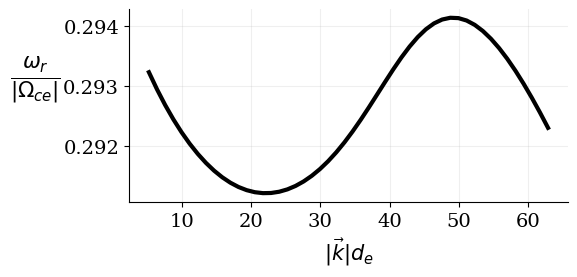

In [31]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_abs, sol_.real, linewidth=3, color="black")
ax.set_ylabel(r'$\frac{\omega_r}{|\Omega_{ce}|}$', fontsize=22, labelpad=20, rotation=0)
ax.set_xlabel(r"$|\vec{k}|d_{e}$", fontsize=15)
#ax.set_ylim(0, 0.7)
##ax.set_xlim(10, 70)
#ax.set_ylim(0.4, 0.6)
#ax.set_yticks([0.4, 0.5, 0.6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("../../figs/vadim_2021/vadim_fig5_c.png", dpi=300, bbox_inches='tight')

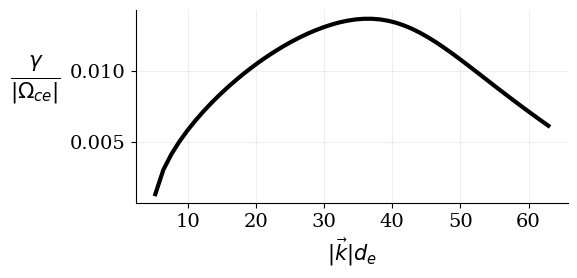

In [32]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(k_abs, sol_.imag, color="black", linewidth=3)
ax.set_ylabel(r'$\frac{\gamma}{|\Omega_{ce}|}$', fontsize=22, labelpad=25, rotation=0)
ax.set_xlabel(r"$|\vec{k}|d_{e}$", fontsize=15)
#ax.set_ylim(-0.0005, 0.012)
#ax.set_yticks([0, 0.005, 0.01])
#ax.set_yticklabels([0, 0.005, 0.01])
#ax.set_xlim(10, 70)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("../../figs/vadim_2021/vadim_fig5_d.png", dpi=300, bbox_inches='tight')

In [33]:
k_perp = 20
k_par =  np.sqrt((omega_0**2) / (1-omega_0**2))*k_perp
omega_ = np.linspace(0.1, 3, 500)

In [34]:
electron_feedback = k_perp**2 + k_par**2 + electron_response(n_c=n_c, omega_pe=omega_pe,
                                                             alpha_c_perp=alpha_c_perp, alpha_c_par=alpha_c_par,
                                                             omega=omega_,
                                                             kz=k_par, ky=k_perp, n_max=50)

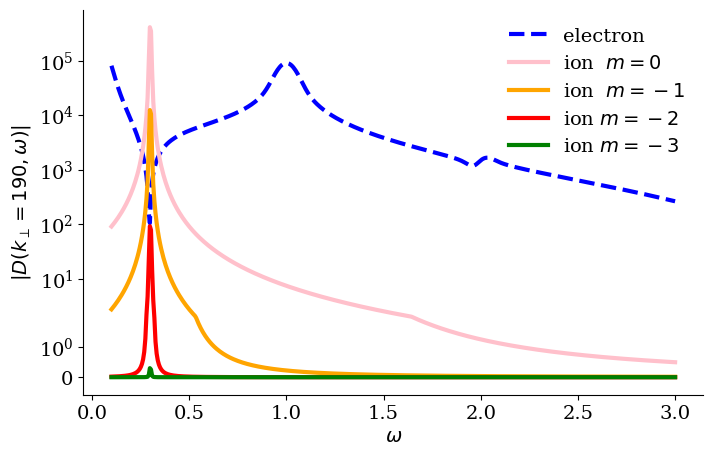

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(omega_, np.abs(electron_feedback), color="blue", ls="--", linewidth=3, label="electron")

ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=0, ky=k_perp, v_0=v_0, omega_0=omega_0, omega=omega_, kz=k_par)), color="pink",  linewidth=3, label="ion  $m=0$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-1, ky=k_perp, v_0=v_0, omega_0=omega_0, omega=omega_, kz=k_par)), color="orange",  linewidth=3, label="ion  $m=-1$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-2, ky=k_perp, v_0=v_0, omega_0=omega_0, omega=omega_, kz=k_par)), color="red",  linewidth=3, label="ion $m=-2$")
ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-3, ky=k_perp, v_0=v_0, omega_0=omega_0, omega=omega_, kz=k_par)), color="green",  linewidth=3, label="ion $m=-3$")
#ax.plot(omega_, np.abs(ion_response(omega_pi=omega_pi, alpha_i=alpha_i, m_star=-4, ky=k_perp, v_0=v_0, omega_0=omega_0, omega=omega_, kz=k_par)), color="purple",  linewidth=3, label="ion $m=-4$")

legend = ax.legend(ncols=1, fancybox=False, shadow=False,  loc="upper right")
legend.get_frame().set_alpha(0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("$\omega$")
ax.set_ylabel("$|D(k_{\perp} =190, \omega)|$")
ax.set_yscale("symlog")
plt.savefig("../../figs/vadim_2021/sidebands_oblique.png", dpi=600)